# Задача 1.3

Проверить мощность и консервативность критерия Уликоксона о равенстве медиан для выборок вида:


$ X_1: ~ \alpha * N(0,1) + (1 - \alpha) * N(2, 4)$

$ X_2: ~ \alpha * N(0,1) + (1 - \alpha) * N(2, 4) + \delta$

Здесь $\delta$ — сдвиг, дающий возможность разделить выборки $X_1$ и $X_2$.

Изучить зависимость от $\alpha$ и $\delta$.

**Важно:** распределение является гауссовой смесью, это не сумма гауссовых величин. [Пример как сэмплировать](https://stackoverflow.com/questions/49106806/how-to-do-a-simple-gaussian-mixture-sampling-and-pdf-plotting-with-numpy-scipy).

In [116]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# параметр для задания толщины линии
plt.rcParams['lines.linewidth'] = 1
# параметр для задания ширины точек
plt.rcParams['lines.markersize'] = 6
# параметр для задания шрифта осей x и y (цифр на осях)
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
# параметр для задания шрифта на осях 
plt.rcParams['legend.fontsize'] = 12
# параметр для задания шрифта заголовка
plt.rcParams['axes.titlesize'] = 32
# параметр для задания шрифта осей x и y (название оси)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['figure.figsize'] = (8.0, 6.0)
# параметр для задания шрифта вспомагательных записей на графику (annotate или text)
plt.rcParams['font.size'] = 13

In [113]:
def sample(n, alpha, delta):
    weights = np.array([alpha, 1 - alpha])
    
    rs = np.random.RandomState()
    mixture_idx = rs.choice(len(weights), size=n, replace=True, p=weights)
    
    # X is the mixture sample
    X = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                       dtype=np.float64) + delta
    return X

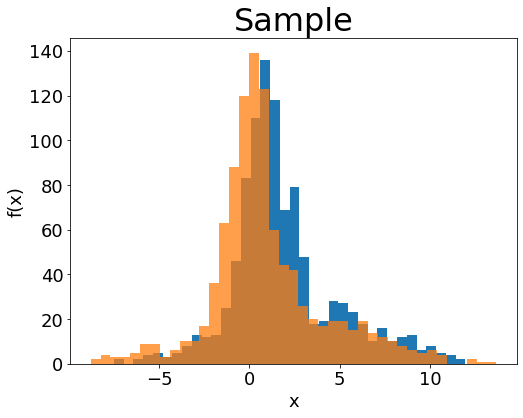

In [117]:
# Set-up
n = 1000

# Parameters of the mixture components
norm_params = np.array([[0, 1],
                        [2, 4]])

# X = sample(n, alpha, delta)
X1 = sample(n, 0.5, 1)
X2 = sample(n, 0.5, 0)

plt.title("Sample")
plt.hist(X1, bins="fd", label='X1')
plt.hist(X2, bins="fd", label='X2', alpha = 0.75)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

#### Уилкоксон (```st.wilcoxon```):

Что мы про него знаем:
 - Критерий знаковых рангов (проверяем на равенство нулю медианы).
 - **Минусы**: предположение о симметричности выборки относительно медианы. Нулевое распределение — считаем всевозможные перестановки рангов (очень накладно).

Случайные величины $\eta_1$ и $\eta_2$ рассматриваются из распределения $F=F(\alpha, \delta)$. Следовательно, равенство медиан выборок нулю аналогично занулению второго параметра.

Гипотезы критерия: $H_0: \delta = 0 \\ H_1: \delta \neq 0$

Мощность критерия — это его способность выявлять различия, если они есть. Иными словами, это способность отклонить нулевую гипотезу об отсутствии различий, если она неверна. Ошибка, состоящая в том, что мы приняли нулевую гипотезу, в то время как она неверна, называется ошибкой II рода.

А его мощность **$W = \mathbb{P}(\text{отвергнуть }Н_0 | \text{верна } H_1) = W(\delta)$**.

Алгоритм измерения мощности:
 - фиксируем $\alpha$ и $\delta$;
 - генерируем $N$ пар выборок, которые будет проверять тестом;
 - для каждой найдем $p-value$ теста Уилкоксон;
 - подсчитаем по доле отвергнутых гипотез мощность критерия.

Вероятно, для избежания зависимости от семлирования выборок и качественного измерения числа отвергнутых гипотез, выборки должны быть большого размера и измерения проводится множество раз.

Предполагается запуск с следующими значениями, $N = 2500, n = 250, \alpha = 0.25, \delta = 1$.

In [49]:
def test(N, n, alpha, delta, power):
    # Итоговая выборка, состоящая из пар для сравнения
    X = []
    rejected = 0
    
    for i in range(N):
        X1 = sample(n, alpha, 0)
        if power:
            X2 = sample(n, alpha, delta)
        else:
            X2 = sample(n, alpha, 0)
        X.append((X1, X2))
        if st.wilcoxon(X1, X2)[1] <= 0.05:
            rejected += 1
    
    return X, rejected / N

In [63]:
N = 2500
n = 250
alpha = 0.25
delta = 1

X, power = test(N, n, alpha, delta, 1)
power

0.8784

Получаем достаточно мощный критерий. Проверим тест на консервативность.

Критерий консервативен — истинная вероятность ошибки первого рода ограничена уровнем значимости сверху.

In [64]:
Y, conservative = test(N, n, alpha, delta, 0)

print(conservative)
if conservative <= 0.05:
    print("Тест консервативен!")
else:
    print("Тест неконсервативен!")

0.0504
Тест неконсервативен!


**Однако мы можем сослаться на ошибку, связанную с случайностью сэплирования (0,0028 довольно мало), и утверждать, что тест консервативен.**

На семинаре было показано, что лучший результат для учета поправки на множественность гипотез будет поправка Бенжамина-Хохберга.

In [65]:
pvalues = []
for X1, X2 in X:
    pvalues.append(st.wilcoxon(X1, X2)[1])

rejects = multipletests(np.array(pvalues), method='fdr_bh', alpha=alpha)[0]
sum(rejects) / N

0.9728

## Рассмотрим зависимость мощности от параметров $\alpha$ и $\delta$

Возьмем $\alpha = 0.5$ (следствие равновероятности компонент распределения) и поменяем параметры, чтобы считалось быстрее.

In [79]:
N = 1000
n = 75
alpha = 0.05
powers = []

for delta in np.arange(-5, 5, 0.5):
    X, _ = test(N, n, alpha, delta, 1)
    pvalues = []
    for X1, X2 in X:
        pvalues.append(st.wilcoxon(X1, X2)[1])
    rejects = multipletests(np.array(pvalues), method='fdr_bh', alpha=alpha)[0]
    powers.append(sum(rejects) / N)

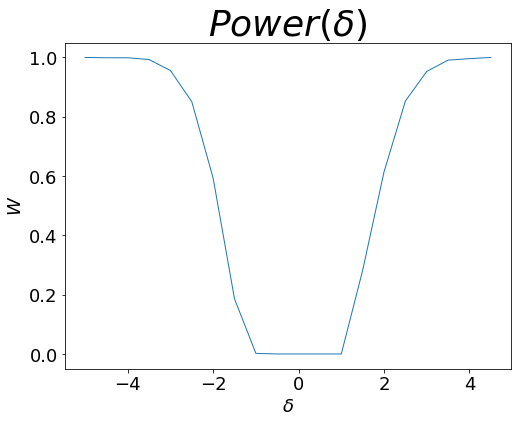

In [86]:
plt.title('$Power(\delta)$')
plt.xlabel('$\delta$')
plt.ylabel('$W$')
plt.plot(np.arange(-5, 5, 0.5), powers)
plt.show()

**Вывод**:
 - график симметричен относительно нуля (наше изнаальное предположение для использования критерия верно);
 - на значениях $-3 \leq \delta \geq 3$ мощность стремиться к 1 $\rightarrow$ при больших $\delta$ критерий хорошо различает выборки;
 - на значениях $-1 \leq delta \leq 1$ мощность около нуля.

Построим график для различных $\alpha$.

In [94]:
N = 1000
n = 50
powers = {}

for alpha in np.arange(0, 1, 0.2):
    powers[alpha] = []
    for delta in np.arange(-4, 4, 0.5):
        X, _ = test(N, n, alpha, delta, 1)
        pvalues = []
        for X1, X2 in X:
            pvalues.append(st.wilcoxon(X1, X2)[1])
        rejects = multipletests(np.array(pvalues), method='fdr_bh', alpha=alpha)[0]
        powers[alpha].append(sum(rejects) / N)

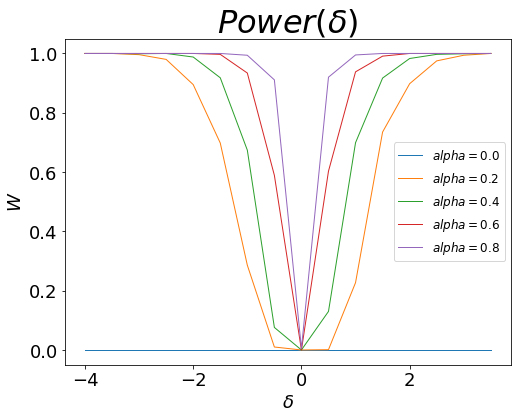

In [123]:
plt.title('$Power(\delta)$')
plt.xlabel('$\delta$')
plt.ylabel('$W$')
for alpha, pows in powers.items():
    plt.plot(np.arange(-4, 4, 0.5), pows, label='$alpha = {}$'.format(alpha.round(1)))
plt.legend(loc="best")
plt.show()

**Вывод**:
 - чем больше $\alpha$, тем меньшее $\delta$ необходимо для получения мощного критерий.